In [1]:
import numpy as np
import pandas as pd

## Step1 data visulization

In [2]:
from sklearn import preprocessing

In [3]:
Black_Friday = pd.read_csv('BlackFriday.csv')

In [4]:
import matplotlib.pyplot as plt

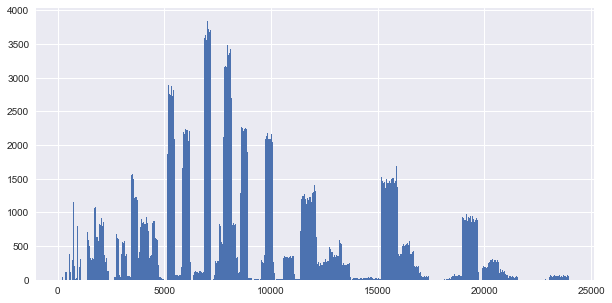

In [475]:
plt.figure(figsize = (10,5))
plt.hist(Black_Friday['Purchase'],
         bins = 1000)
sns.set()
plt.show()

In [5]:
Black_Friday['Rating'] = Black_Friday['Purchase']//5000

## Step2 model definition

In [6]:
def r_prediction(mu, b_U, b_I, p, q):
    prediction = mu + b_U[:,np.newaxis] + b_I[np.newaxis,:] + np.dot(p, q.T)
    return prediction

## Step 3&4 data preprocessing

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
ratings = Black_Friday[['User_ID','Product_ID','Rating']]
User =  Black_Friday['User_ID'].unique()
Product =  Black_Friday['Product_ID'].unique()

In [9]:
le = preprocessing.LabelEncoder()
ratings['User_ID'] = le.fit_transform(ratings['User_ID'])
User = np.sort(le.transform(User))

le = preprocessing.LabelEncoder()
ratings['Product_ID'] = le.fit_transform(ratings['Product_ID'])
Product = np.sort(le.transform(Product))

C:\Users\wsyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wsyou\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
ratings_train, ratings_test = train_test_split(ratings,test_size=0.2)
ratings_train, ratings_validation = train_test_split(ratings_train,test_size=0.2)

In [148]:
Black_Friday['Purchase'].sum()/U

851751.5494822611

In [150]:
I

3623

## Step5 initial parameters

In [11]:
U = len(User)
I = len(Product)

In [12]:
def initial_parameters(U,I,F):
    b_U_0 = np.random.normal(0,1e-4,U)
    b_I_0 = np.random.normal(0,1e-4,I)
    p_0 = np.random.normal(0,1/max(1,F**(1/2)),(U,F))
    q_0 = np.random.normal(0,1/max(1,F**(1/2)),(I,F))
    return b_U_0, b_I_0, p_0, q_0

## Step6 Loss function, gradient function and SGD function

In [13]:
def Loss(b_U,b_I,p,q,R):
    N = len(R)
    r_pre = mu + b_U[R['User_ID']] + b_I[R['Product_ID']] + np.sum(p[R['User_ID']]*q[R['Product_ID']],axis=1)
    loss = sum((r_pre-R['Rating'])**2)/N
    penalty = lambda_p/2*np.sum(p**2)*np.sum(q**2)/N
    return loss+penalty

In [15]:
def Gradient(b_U,b_I,p,q,R):
    N = len(R)
    R_temp = R
    r_pre = mu + b_U[R['User_ID']] + b_I[R['Product_ID']] + np.sum(p[R['User_ID']]*q[R['Product_ID']],axis=1)
    delta = R['Rating'] - r_pre
    R_temp['delta'] = delta

    #R_temp['q*r'] = q[R['MovieID']]*delta[:,np.newaxis]
    R_qr = pd.DataFrame(q[R['Product_ID']]*delta[:,np.newaxis],index=R['User_ID'])
    #R_temp['p*r'] = p[R['UserID']]*delta[:,np.newaxis]
    R_pr = pd.DataFrame(p[R['User_ID']]*delta[:,np.newaxis],index=R['Product_ID'])
    
    U_dict = R_temp.groupby('User_ID')['delta'].sum().to_dict()
    I_dict = R_temp.groupby('Product_ID')['delta'].sum().to_dict()
    
    qr = R_qr.groupby('User_ID').sum()
    pr = R_pr.groupby('Product_ID').sum()
    
    for i in range(len(b_U)):
        if i not in U_dict:
            U_dict[i] = 0
            qr.loc[i] = np.zeros(F)
    for i in range(len(b_I)):
        if i not in I_dict:
            I_dict[i] = 0
            pr.loc[i] = np.zeros(F)
            
    qr.sort_index(inplace = True)
    pr.sort_index(inplace = True)
            
    delta_b_U = -2/N*np.array(list(U_dict.values()))
    delta_b_I = -2/N*np.array(list(I_dict.values()))
    delta_p = -2/N*np.reshape(np.array(qr),(-1,F)) + lambda_p*p/N
    delta_q = -2/N*np.reshape(np.array(pr),(-1,F)) + lambda_p*q/N
    
    return delta_b_U, delta_b_I, delta_p, delta_q

In [16]:
def StochasticGradientDescent(b_U,b_I,p,q,Ratings,learning_rate=1e-4,tol=1e-7,max_iter=20,batch_size=500000):
    import warnings
    warnings.filterwarnings("ignore")
    N = Ratings.shape[0]
    for e in range(max_iter):
        print(e)
#         if (e%(max_iter//10)==0):
#             print('...' + str(e) + 'Loss:' + str(L))
        perm=np.random.permutation(N)
        for i in range(0,N,batch_size):
            R = Ratings.iloc[perm[i:i+batch_size]]
            delta_b_U, delta_b_I, delta_p, delta_q = Gradient(b_U,b_I,p,q,R)
            b_U = -1*learning_rate*delta_b_U + b_U
            b_I = -1*learning_rate*delta_b_I + b_I
            p = -1*learning_rate*delta_p + p
            q = -1*learning_rate*delta_q + q
        L = Loss(b_U,b_I,p,q,Ratings)
        if L < tol:
            break
    return b_U,b_I,p,q

In [48]:
def NewStochasticGradientDescent(b_U,b_I,p,q,Ratings,learning_rate=1e-4,tol=1e-7,max_iter=1,batch_size=100000):
    b_U_,b_I_,p_,q_ = b_U.copy(),b_I.copy(),p.copy(),q.copy()
    import warnings
    warnings.filterwarnings("ignore")
    N = Ratings.shape[0]
    for e in range(max_iter):
        print(e)
#         if (e%(max_iter//10)==0):
#             print('...' + str(e) + 'Loss:' + str(L))
        perm=np.random.permutation(N)
        for batch in range(0,N,batch_size):
            print('batch')
            R = Ratings.iloc[perm[batch:batch+batch_size]]
            for index, r in R.iterrows():
                u = int(r['User_ID'])
                i = int(r['Product_ID'])
                r_pre = mu + b_U[u] + b_I[i] + np.sum(p[u]*q[i])
                delta = r['Rating'] - r_pre
                delta_b_U = -2 * delta
                delta_b_I = -2 * delta
                delta_p = -2 * q[i] * delta + lambda_p * p[u]
                delta_q = -2 * p[u] * delta + lambda_p * q[i]

                b_U_[u] = -1*learning_rate*delta_b_U + b_U[u]
                b_I_[i] = -1*learning_rate*delta_b_I + b_I[i]
                p_[u] = -1*learning_rate*delta_p + p[u]
                q_[i] = -1*learning_rate*delta_q + q[i]
#         L = Loss(b_U,b_I,p,q,Ratings)
#         if L < tol:
#             break
    return b_U_,b_I_,p_,q_

In [103]:
def Loss_NewStochasticGradientDescent(b_U,b_I,p,q,Ratings,learning_rate=1e-4,tol=1e-7,max_iter=1,batch_size=100000):
    Loss_list = []
    b_U_,b_I_,p_,q_ = b_U.copy(),b_I.copy(),p.copy(),q.copy()
    import warnings
    warnings.filterwarnings("ignore")
    N = Ratings.shape[0]
    for e in range(max_iter):
        print(e)
#         if (e%(max_iter//10)==0):
#             print('...' + str(e) + 'Loss:' + str(L))
        perm=np.random.permutation(N)
        for batch in range(0,N,batch_size):
            #print('batch')
            R = Ratings.iloc[perm[batch:batch+batch_size]]
            for index, r in R.iterrows():
                u = int(r['User_ID'])
                i = int(r['Product_ID'])
                r_pre = mu + b_U[u] + b_I[i] + np.sum(p[u]*q[i])
                delta = r['Rating'] - r_pre
                delta_b_U = -2 * delta
                delta_b_I = -2 * delta
                delta_p = -2 * q[i] * delta + lambda_p * p[u]
                delta_q = -2 * p[u] * delta + lambda_p * q[i]

                b_U_[u] = -1*learning_rate*delta_b_U + b_U[u]
                b_I_[i] = -1*learning_rate*delta_b_I + b_I[i]
                p_[u] = -1*learning_rate*delta_p + p[u]
                q_[i] = -1*learning_rate*delta_q + q[i]
            Loss_list.append(MSE(b_U_,b_I_,p_,q_,Ratings))
            if len(Loss_list) > 100:
                break
   

    return Loss_list

In [24]:
def MSE(b_U,b_I,p,q,R):
    N = len(R)
    r_pre = mu + b_U[R['User_ID']] + b_I[R['Product_ID']] + np.sum(p[R['User_ID']]*q[R['Product_ID']],axis=1)
    mse = sum((r_pre-R['Rating'])**2)/N
    return mse

In [25]:
F = 20
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)

In [26]:
mu = 1.4
lambda_p = 0.5

In [27]:
F = 20
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
np.sum(p_0[1:3000]*q_0[1:3000],axis = 1).sum()

8.45352821469204

## Step7 

## define learning rate

In [2]:
learning_rate = 0.2

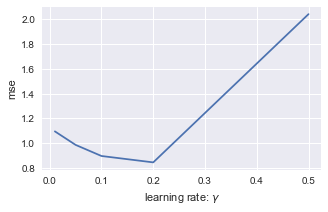

In [492]:
plt.figure(figsize=(5,3))
plt.xlabel('learning rate: $\gamma$')
plt.ylabel('mse')
#plt.ylim(0, 1)
sns.set()
plt.plot([0.01,0.05,0.1,0.2,0.5], mse_list)
plt.show()

## initial F

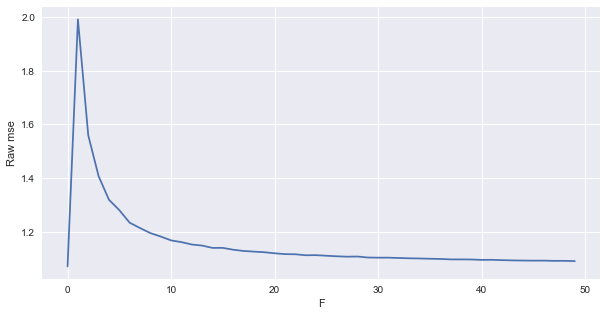

In [469]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.xlabel('F')
plt.ylabel('Raw mse')
sns.set()
plt.plot(F_list, mse_list)
plt.show()

## Step 8 test and code running part

In [32]:
mu = 1.4
lambda_p = 0.01

In [33]:
ratings['Rating'].mean()

1.4068905477726912

In [34]:
# mse_list = list()
# for F in [1,2,4,8,10]:
#     print('F = ', F)
#     b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
#     b_U, b_I, p, q = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=1e-4,tol=5e-7,max_iter=25,batch_size=300000)
#     mse_list.append(MSE(b_U,b_I,p,q,ratings_test))

In [35]:
F = 5
b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)

In [36]:
# for F in [15,20,30,50]:
#     print('F = ', F)
#     b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
#     b_U, b_I, p, q = StochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=1e-4,tol=5e-7,max_iter=25,batch_size=300000)
#     mse_list.append(MSE(b_U,b_I,p,q,ratings_test))

In [37]:
# mse_list

In [38]:
# MSE(b_U_0,b_I_0,p_0,q_0,ratings_test)

In [92]:
test = Loss_NewStochasticGradientDescent(b_U_0,b_I_0,p_0,q_0,ratings_train,learning_rate=.2,tol=5e-7,max_iter=1,batch_size = 100)

0


In [88]:
Loss(b_U_0,b_I_0,p_0,q_0,ratings_train)

1.4396436686711924

In [80]:
Loss(b_U_0, b_I_0, p_0, q_0,ratings_train.iloc[1:100000])

11.933400449617627

In [166]:
b_U, b_I, p, q = NewStochasticGradientDescent(b_U,b_I,p,q,ratings_train,learning_rate=20,tol=5e-7,max_iter=5,batch_size=50000)

0
1
2
3
4


## model performance

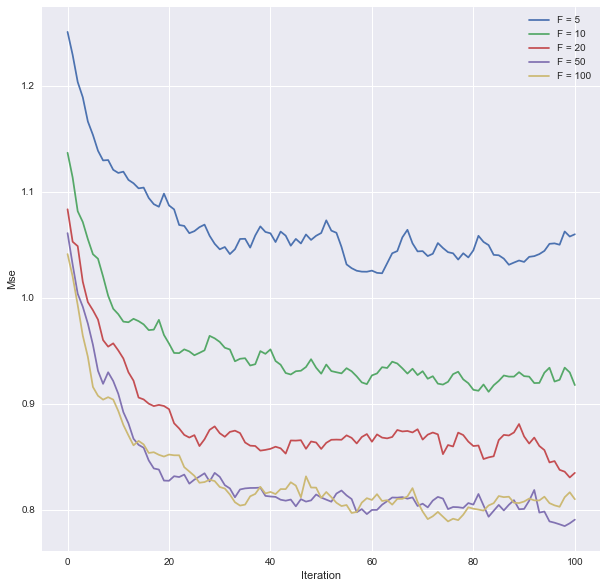

In [135]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.xlabel('Iteration')
plt.ylabel('Mse')
sns.set()
for i in range(1,len(mse_list)):
    plt.plot(mse_list[i], label = f'F = {[1,5,10,20,50,100][i]}')
plt.legend()
plt.show()

In [450]:
F_list = [F for F in range(50)]
mse_list = []
mu = 1.4
for number in F_list:
    F = number
    b_U_0, b_I_0, p_0, q_0 = initial_parameters(U,I,F)
    mse_list.append(MSE(b_U_0,b_I_0,p_0,q_0,ratings_train))

In [448]:
import matplotlib.pyplot as plt

In [157]:
ratings['Rating'].mean()

1.4068905477726912